# DINOv3 Image Retrieval Analysis Framework

## Overview

This notebook provides a comprehensive image retrieval evaluation framework for DINOv3 models, implementing standard retrieval metrics and methodologies used in computer vision research.

### Key Features:
- **Dual Model Analysis**: Compare original pretrained vs fine-tuned DINOv3 models
- **Standard Metrics**: Top-K Accuracy, Recall@K, mean Average Precision (mAP)
- **Stratified Evaluation**: Ensures fair comparison with class overlap between query/gallery sets
- **Professional Visualizations**: Retrieval examples, performance comparisons, confusion matrices
- **Flexible Dataset Support**: Custom datasets and HuggingFace datasets

### Evaluation Methodology:

**Image Retrieval Task**: Given a query image, rank all gallery images by similarity and evaluate how well the model retrieves relevant (same class) images.

**Mathematical Foundations**:

1. **Feature Similarity**: 
   $$\text{sim}(q_i, g_j) = \frac{f(q_i) \cdot f(g_j)}{||f(q_i)|| \cdot ||f(g_j)||}$$
   where $f(\cdot)$ represents DINOv3 feature extraction

2. **Top-K Accuracy**:
   $$\text{Acc@K} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \mathbf{1}[c_{q_i} \in \text{top-K}(q_i)]$$

3. **Recall@K**:
   $$\text{Recall@K} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{|\{g \in \text{top-K}(q_i) : c_g = c_{q_i}\}|}{|\{g \in G : c_g = c_{q_i}\}|}$$

4. **Mean Average Precision**:
   $$\text{mAP} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \text{AP}(q_i)$$
   where $\text{AP}(q_i) = \sum_{k=1}^{|G|} P@k \cdot \text{rel}(k)$

Configure the models and dataset below to perform comprehensive retrieval analysis.

In [1]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Analysis libraries
from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Setup paths
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)
dinov3_path = os.path.join(project_root, "dinov3")
sys.path.insert(0, dinov3_path)

# Import custom modules
from data.custom_dataset import CustomImageDataset
from data.huggingface_dataset import HuggingFaceDataset
from src.models.dinov3_lightning_model import DINOv3LightningModule

# Professional plotting style
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'lines.linewidth': 2,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Color scheme
COLORS = {
    'original': '#2E86AB',
    'finetuned': '#A23B72',
    'accent': '#F18F01',
    'positive': '#06A77D',
    'negative': '#C73E1D'
}

print("Libraries imported and styling configured")

/home/marjans/anaconda3/envs/dlv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.8.0 available.


Libraries imported and styling configured


## Configuration and Setup

This section configures all parameters for the image retrieval analysis. The notebook supports flexible configuration for different experimental setups.

In [2]:
# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

class RetrievalConfig:
    """Configuration class for image retrieval experiments"""
    
    # Model Selection
    USE_ORIGINAL_MODEL = True   # Include original pretrained DINOv3
    USE_FINETUNED_MODEL = True  # Include fine-tuned DINOv3
    
    # Dataset Configuration
    DATASET_TYPE = "huggingface"  # Options: "custom", "huggingface"
    
    # Custom Dataset Settings (used if DATASET_TYPE == "custom")
    CUSTOM_DATASET_PATH = '../../Datasets/composite/'
    
    # HuggingFace Dataset Settings (used if DATASET_TYPE == "huggingface")
    HF_DATASET_NAME = 'jonathancui/oxford-pets'  # Popular datasets: 'imagenet-1k', 'cifar10', 'oxford-pets'
    HF_SPLIT = None          # None for all splits, or specify 'train', 'test', etc.
    HF_IMAGE_KEY = 'image'   # Column containing images
    HF_LABEL_KEY = 'label'   # Column containing class labels
    
    # Retrieval Evaluation Parameters
    K_VALUES = [1, 5, 10, 20]      # Top-K values for evaluation metrics
    NUM_QUERY_SAMPLES = 100        # Number of query samples (smaller for faster evaluation)
    NUM_GALLERY_SAMPLES = 500      # Number of gallery samples  
    BATCH_SIZE = 32                # Batch size for feature extraction
    RANDOM_SEED = 42               # For reproducible results
    
    # Visualization Parameters
    NUM_RETRIEVAL_EXAMPLES = 5     # Number of retrieval examples to visualize
    TOP_K_DISPLAY = 5              # Number of top retrievals to show per query
    
    # Advanced Settings
    SIMILARITY_METRIC = "cosine"   # Options: "cosine", "euclidean", "dot_product"
    FEATURE_NORMALIZATION = True   # Normalize features before similarity computation
    STRATIFIED_SAMPLING = True     # Ensure class overlap between query/gallery

# ============================================================================
# SYSTEM CONFIGURATION  
# ============================================================================

import torch
from pathlib import Path
import numpy as np

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# Get project root
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)

# Model paths - Update these paths according to your setup
MODEL_PATHS = {
    'original': os.path.join(project_root, 'dinov3_official_weights', 'dinov3_vits16_pretrain_lvd1689m-08c60483.pth'),
    'finetuned': os.path.join(project_root, 'output_hf', 'checkpoints', 'model_epoch_epoch=00_step_step=049000_loss_total_loss=8.093750.ckpt'),
    'config': os.path.join(project_root, 'configs', 'config_lightning_finetuning_v2.yaml')
}

# Output directory for results
OUTPUT_DIR = Path('./retrieval_results')
OUTPUT_DIR.mkdir(exist_ok=True)

# Set random seeds for reproducibility
torch.manual_seed(RetrievalConfig.RANDOM_SEED)
np.random.seed(RetrievalConfig.RANDOM_SEED)

# Display configuration summary
print("Configuration Summary:")
print(f"  Dataset: {RetrievalConfig.DATASET_TYPE}")
if RetrievalConfig.DATASET_TYPE == "huggingface":
    print(f"    HuggingFace dataset: {RetrievalConfig.HF_DATASET_NAME}")
else:
    print(f"    Custom dataset path: {RetrievalConfig.CUSTOM_DATASET_PATH}")
print(f"  Models: Original={RetrievalConfig.USE_ORIGINAL_MODEL}, Fine-tuned={RetrievalConfig.USE_FINETUNED_MODEL}")
print(f"  Evaluation: {RetrievalConfig.NUM_QUERY_SAMPLES} queries, {RetrievalConfig.NUM_GALLERY_SAMPLES} gallery")
print(f"  Metrics: Top-K for K={RetrievalConfig.K_VALUES}")
print(f"  Similarity: {RetrievalConfig.SIMILARITY_METRIC} distance")
print(f"  Results will be saved to: {OUTPUT_DIR}")

# Verify model files exist
print("\nModel File Verification:")
for model_type, path in MODEL_PATHS.items():
    exists = os.path.exists(path)
    status = "Found" if exists else "Missing"
    print(f"  {model_type}: {status}")

print("=" * 70)

Device: cuda
Configuration Summary:
  Dataset: huggingface
    HuggingFace dataset: jonathancui/oxford-pets
  Models: Original=True, Fine-tuned=True
  Evaluation: 100 queries, 500 gallery
  Metrics: Top-K for K=[1, 5, 10, 20]
  Similarity: cosine distance
  Results will be saved to: retrieval_results

Model File Verification:
  original: Found
  finetuned: Found
  config: Found


## Model Loading and Feature Extraction

This section handles loading the DINOv3 models and implementing the feature extraction pipeline. We extract CLS token features from the teacher backbone for both original pretrained and fine-tuned models.

In [3]:
class ModelLoader:
    """Handles loading and management of DINOv3 models"""
    
    def __init__(self, device=DEVICE):
        self.device = device
        self.models = {}
        
    def load_original_model(self):
        """Load original pretrained DINOv3 model using torch.hub"""
        try:
            print("Loading original DINOv3 model via torch.hub...")
            
            # Load DINOv3 ViT-S/16 model using local weights
            dinov3_hub_path = os.path.join(project_root, 'dinov3')
            model = torch.hub.load(
                dinov3_hub_path, 
                'dinov3_vits16', 
                source='local',
                weights=MODEL_PATHS['original'],
                pretrained=True
            )
            
            model.to(self.device)
            model.eval()
            
            print("  Original model loaded successfully")
            return model
            
        except Exception as e:
            print(f"  Failed to load original model: {e}")
            return None

    def load_finetuned_model(self):
        """Load fine-tuned DINOv3 Lightning model"""
        try:
            print("Loading fine-tuned DINOv3 model...")
            
            # Load Lightning checkpoint
            lightning_model = DINOv3LightningModule.load_from_checkpoint(
                MODEL_PATHS['finetuned'],
                cfg_path=MODEL_PATHS['config'],
                map_location=self.device,
                strict=True
            )
            
            # Extract teacher backbone for feature extraction
            model = lightning_model.ssl_model.teacher.backbone
            model.eval()
            
            print("  Fine-tuned model loaded successfully")
            return model
            
        except Exception as e:
            print(f"  Failed to load fine-tuned model: {e}")
            return None
    
    def load_models(self, use_original=True, use_finetuned=True):
        """Load requested models based on configuration"""
        print("Model Loading")
        print("=" * 50)
        
        if use_original:
            original_model = self.load_original_model()
            if original_model is not None:
                self.models['original'] = original_model
                
        if use_finetuned:
            finetuned_model = self.load_finetuned_model()
            if finetuned_model is not None:
                self.models['finetuned'] = finetuned_model
        
        print(f"Models loaded: {list(self.models.keys())}")
        return self.models

class FeatureExtractor:
    """Handles feature extraction from DINOv3 models"""
    
    def __init__(self, device=DEVICE):
        self.device = device
    
    def extract_features(self, model, dataloader, model_name):
        """Extract CLS token features from DINOv3 model"""
        features = []
        labels = []
        
        print(f"Extracting features from {model_name} model...")
        print(f"  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)")
        
        model.eval()  # Ensure evaluation mode
        with torch.no_grad():
            for images, batch_labels in tqdm(dataloader, desc=f"Processing {model_name}"):
                images = images.to(self.device)
                
                # Forward pass through DINOv3
                outputs = model(images)
                
                # Extract CLS token features
                if hasattr(outputs, 'shape') and len(outputs.shape) == 2:
                    cls_features = outputs
                else:
                    cls_features = outputs[:, 0] if len(outputs.shape) > 2 else outputs
                    
                features.append(cls_features.cpu().numpy())
                labels.extend(batch_labels.numpy())
        
        # Concatenate all features and convert labels
        features = np.vstack(features)
        labels = np.array(labels)
        
        print(f"  Extracted {model_name} features: {features.shape}")
        print(f"  Feature statistics: mean={features.mean():.4f}, std={features.std():.4f}")
        
        return features, labels

# Initialize components
model_loader = ModelLoader()
feature_extractor = FeatureExtractor()

# Load models based on configuration
models = model_loader.load_models(
    use_original=RetrievalConfig.USE_ORIGINAL_MODEL,
    use_finetuned=RetrievalConfig.USE_FINETUNED_MODEL
)

print(f"Ready for feature extraction with {len(models)} model(s)")

INFO:dinov3:using base=100 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=2 for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=fp32 for rope new
INFO:dinov3:using mlp layer as FFN


Model Loading
Loading original DINOv3 model via torch.hub...
  Original model loaded successfully
Loading fine-tuned DINOv3 model...


INFO:dinov3_lightning:Building DINOv3 SSL model...
INFO:dinov3:using base=100.0 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=None for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=bf16 for rope new
INFO:dinov3:using mlp layer as FFN
INFO:dinov3:fp8 matmuls: OFF (disabled in config)
INFO:dinov3:using base=100.0 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=None for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=bf16 for rope new
INFO:dinov3:using mlp layer as FFN
INFO:dinov3:fp8 matmuls: OFF (disabled in config)
INFO:dino

  Fine-tuned model loaded successfully
Models loaded: ['original', 'finetuned']
Ready for feature extraction with 2 model(s)


In [4]:
class DatasetManager:
    """Simple dataset loading and splitting for image retrieval evaluation"""
    
    def __init__(self, config):
        self.config = config
        self.dataset = None
        self.label_names = {}
        self.dataset_name = ""
        
        # Standard image transforms for DINOv3
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def load_dataset(self):
        """Load dataset based on configuration"""
        print("Dataset Loading")
        print("="*50)
        
        if self.config.DATASET_TYPE == "custom":
            return self._load_custom_dataset()
        elif self.config.DATASET_TYPE == "huggingface":
            return self._load_huggingface_dataset()
        else:
            raise ValueError(f"Unsupported dataset type: {self.config.DATASET_TYPE}")
    
    def _load_custom_dataset(self):
        """Load custom dataset from local directory"""
        print(f"Loading custom dataset from: {self.config.CUSTOM_DATASET_PATH}")
        
        self.dataset = CustomImageDataset(
            root=self.config.CUSTOM_DATASET_PATH, 
            transform=self.transform, 
            recursive=True
        )
        
        print(f"Custom dataset loaded: {len(self.dataset)} images")
        
        # Extract class information from filenames
        cell_names = []
        for image_path in self.dataset.image_paths:
            fname = Path(image_path).stem
            cell_name = "_".join(fname.split("_")[3:])
            cell_names.append(cell_name)
        
        # Create label mapping
        unique_classes = sorted(set(cell_names))
        self.label_names = {idx: cls for idx, cls in enumerate(unique_classes)}
        self.dataset_name = "Custom Dataset"
        
        print(f"Found {len(unique_classes)} classes")
        return self.dataset
    
    def _load_huggingface_dataset(self):
        """Load HuggingFace dataset"""
        print(f"Loading HuggingFace dataset: {self.config.HF_DATASET_NAME}")
        
        self.dataset = HuggingFaceDataset(
            name=self.config.HF_DATASET_NAME,
            split=self.config.HF_SPLIT,
            transform=self.transform,
            image_key=self.config.HF_IMAGE_KEY,
            label_key=self.config.HF_LABEL_KEY,
            streaming=False
        )
        
        print(f"HuggingFace dataset loaded: {len(self.dataset)} samples")
        
        # Extract label information from dataset features
        hf_dataset = self.dataset.dataset
        label_feature = hf_dataset.features[self.config.HF_LABEL_KEY]
        self.label_names = {i: name for i, name in enumerate(label_feature.names)}
        self.dataset_name = self.config.HF_DATASET_NAME
        
        unique_classes = list(self.label_names.values())
        print(f"Classes: {len(unique_classes)} ({', '.join(unique_classes[:5])}{'...' if len(unique_classes) > 5 else ''})")
        
        return self.dataset
    
    def create_simple_splits(self):
        """
        Create simple random query and gallery splits
        Much simpler approach - just random sampling
        """
        print("Creating query and gallery splits...")
        
        # Simple random split
        total_samples = len(self.dataset)
        max_total = self.config.NUM_QUERY_SAMPLES + self.config.NUM_GALLERY_SAMPLES
        
        if total_samples > max_total:
            # Use random subset if dataset is too large
            indices = torch.randperm(total_samples)[:max_total].tolist()
        else:
            indices = list(range(total_samples))
        
        # Split indices
        query_size = min(self.config.NUM_QUERY_SAMPLES, len(indices) // 4)  # 25% for queries
        
        query_indices = indices[:query_size]
        gallery_indices = indices[query_size:]
        
        print(f"Query set: {len(query_indices)} samples")
        print(f"Gallery set: {len(gallery_indices)} samples")
        
        # Create datasets
        query_dataset = torch.utils.data.Subset(self.dataset, query_indices)
        gallery_dataset = torch.utils.data.Subset(self.dataset, gallery_indices)
        
        query_dataloader = DataLoader(query_dataset, batch_size=self.config.BATCH_SIZE, shuffle=False, num_workers=4)
        gallery_dataloader = DataLoader(gallery_dataset, batch_size=self.config.BATCH_SIZE, shuffle=False, num_workers=4)
        
        # Extract labels
        print("Extracting labels...")
        
        # Get query labels
        query_labels = []
        for _, labels in query_dataloader:
            query_labels.extend(labels.numpy())
        query_labels = np.array(query_labels)
        
        # Get gallery labels  
        gallery_labels = []
        for _, labels in gallery_dataloader:
            gallery_labels.extend(labels.numpy())
        gallery_labels = np.array(gallery_labels)
        
        # Check class overlap
        query_classes = set(query_labels)
        gallery_classes = set(gallery_labels)
        common_classes = query_classes & gallery_classes
        
        print(f"Query classes: {len(query_classes)}")
        print(f"Gallery classes: {len(gallery_classes)}")
        print(f"Common classes: {len(common_classes)}")
        
        return query_dataloader, gallery_dataloader, query_labels, gallery_labels

# Initialize dataset manager
print("Initializing dataset manager...")
dataset_manager = DatasetManager(RetrievalConfig)
dataset = dataset_manager.load_dataset()

# Create simple splits
query_dataloader, gallery_dataloader, query_labels, gallery_labels = dataset_manager.create_simple_splits()

print(f"Dataset preparation complete!")
print(f"Dataset: {dataset_manager.dataset_name}")
print(f"Ready for feature extraction with {len(query_labels)} queries and {len(gallery_labels)} gallery images")

INFO:dinov3:Loading Hugging Face dataset: jonathancui/oxford-pets


Initializing dataset manager...
Dataset Loading
Loading HuggingFace dataset: jonathancui/oxford-pets


INFO:dinov3:Available splits: ['train', 'test']
INFO:dinov3:Concatenated 2 splits: ['train', 'test']
INFO:dinov3:Dataset columns: ['image', 'label']
INFO:dinov3:Dataset size: 7,349 samples


HuggingFace dataset loaded: 7349 samples
Classes: 37 (Abyssinian, Bengal, Birman, Bombay, British_Shorthair...)
Creating query and gallery splits...
Query set: 100 samples
Gallery set: 500 samples
Extracting labels...
Query classes: 35
Gallery classes: 37
Common classes: 35
Dataset preparation complete!
Dataset: jonathancui/oxford-pets
Ready for feature extraction with 100 queries and 500 gallery images


## Feature Extraction

In [5]:
# Extract features for all loaded models
print("\n" + "=" * 50)
print("FEATURE EXTRACTION")
print("=" * 50)

query_features = {}
gallery_features = {}

for model_name, model in models.items():
    print(f"\nProcessing {model_name} model...")
    
    # Extract query features
    print("  Extracting query features...")
    q_feats, q_labels = feature_extractor.extract_features(
        model, query_dataloader, f"{model_name} (query)"
    )
    query_features[model_name] = q_feats
    
    # Extract gallery features  
    print("  Extracting gallery features...")
    g_feats, g_labels = feature_extractor.extract_features(
        model, gallery_dataloader, f"{model_name} (gallery)"
    )
    gallery_features[model_name] = g_feats
    
    print(f"  {model_name} feature extraction complete")
    print(f"      Query features: {q_feats.shape}")
    print(f"      Gallery features: {g_feats.shape}")

# Verify labels consistency (should be same for all models)
query_labels_final = q_labels
gallery_labels_final = g_labels

print(f"\nFeature extraction summary:")
print(f"  Models processed: {list(query_features.keys())}")
print(f"  Query set: {len(query_labels_final)} samples")
print(f"  Gallery set: {len(gallery_labels_final)} samples")
print(f"  Feature dimension: {list(query_features.values())[0].shape[1]} (DINOv3 CLS token)")

# Verify class overlap in final splits
final_query_classes = set(query_labels_final)
final_gallery_classes = set(gallery_labels_final) 
final_common_classes = final_query_classes & final_gallery_classes
print(f"  Common classes: {len(final_common_classes)}/{len(final_query_classes)} query classes have matches in gallery")

print("\nReady for retrieval evaluation!")


FEATURE EXTRACTION

Processing original model...
  Extracting query features...
Extracting features from original (query) model...
  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)


Processing original (query): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


  Extracted original (query) features: (100, 384)
  Feature statistics: mean=0.0006, std=0.4713
  Extracting gallery features...
Extracting features from original (gallery) model...
  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)


Processing original (gallery): 100%|██████████| 16/16 [00:01<00:00, 13.39it/s]


  Extracted original (gallery) features: (500, 384)
  Feature statistics: mean=0.0005, std=0.4716
  original feature extraction complete
      Query features: (100, 384)
      Gallery features: (500, 384)

Processing finetuned model...
  Extracting query features...
Extracting features from finetuned (query) model...
  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)


Processing finetuned (query): 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


  Extracted finetuned (query) features: (100, 384)
  Feature statistics: mean=-0.0010, std=0.5198
  Extracting gallery features...
Extracting features from finetuned (gallery) model...
  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)


Processing finetuned (gallery): 100%|██████████| 16/16 [00:01<00:00, 13.64it/s]


  Extracted finetuned (gallery) features: (500, 384)
  Feature statistics: mean=-0.0011, std=0.5186
  finetuned feature extraction complete
      Query features: (100, 384)
      Gallery features: (500, 384)

Feature extraction summary:
  Models processed: ['original', 'finetuned']
  Query set: 100 samples
  Gallery set: 500 samples
  Feature dimension: 384 (DINOv3 CLS token)
  Common classes: 35/35 query classes have matches in gallery

Ready for retrieval evaluation!


## Image Retrieval Analysis Framework

This section implements the core image retrieval evaluation methodology with standard metrics used in computer vision research.

### Mathematical Foundations

Given:
- **Query set** $Q = \{q_1, q_2, ..., q_{|Q|}\}$ with labels $\{c_{q_1}, c_{q_2}, ..., c_{q_{|Q|}}\}$
- **Gallery set** $G = \{g_1, g_2, ..., g_{|G|}\}$ with labels $\{c_{g_1}, c_{g_2}, ..., c_{g_{|G|}}\}$  
- **Feature extractor** $f(\cdot): \mathbb{R}^{H \times W \times 3} \rightarrow \mathbb{R}^d$ (DINOv3 CLS token, $d=384$)

### Similarity Computation

**Cosine Similarity** (most common for neural features):
$$\text{sim}(q_i, g_j) = \frac{f(q_i) \cdot f(g_j)}{||f(q_i)||_2 \cdot ||f(g_j)||_2}$$

### Evaluation Metrics

1. **Top-K Accuracy**: Percentage of queries where correct class appears in top-K results
   $$\text{Acc@K} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \mathbf{1}[c_{q_i} \in \text{top-K}(q_i)]$$

2. **Mean Average Precision (mAP)**: Considers ranking quality
   $$\text{mAP} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \text{AP}(q_i)$$

In [6]:
class RetrievalAnalyzer:
    """Simple image retrieval analysis with standard evaluation metrics"""
    
    def __init__(self, config):
        self.config = config
        self.k_values = config.K_VALUES
        
    def compute_similarity_matrix(self, query_features, gallery_features):
        """Compute cosine similarity matrix between query and gallery features"""
        # L2 normalize features for cosine similarity
        query_norm = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
        gallery_norm = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)
        
        # Compute cosine similarity matrix
        similarity_matrix = np.dot(query_norm, gallery_norm.T)
        return similarity_matrix
    
    def compute_retrieval_metrics(self, similarity_matrix, query_labels, gallery_labels):
        """Compute retrieval metrics"""
        metrics = {}
        num_queries = len(query_labels)
        
        # Sort gallery indices by similarity (descending order)
        sorted_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1]
        
        # Compute Top-K accuracies
        for k in self.k_values:
            top_k_indices = sorted_indices[:, :k]
            correct_at_k = 0
            
            for i, query_label in enumerate(query_labels):
                top_k_gallery_labels = gallery_labels[top_k_indices[i]]
                if query_label in top_k_gallery_labels:
                    correct_at_k += 1
            
            metrics[f'Top-{k}_Accuracy'] = correct_at_k / num_queries
        
        # Compute mean Average Precision (mAP)
        ap_scores = []
        for i, query_label in enumerate(query_labels):
            relevant_mask = (gallery_labels == query_label)
            num_relevant = relevant_mask.sum()
            
            if num_relevant == 0:
                continue
            
            query_scores = similarity_matrix[i]
            try:
                ap = average_precision_score(relevant_mask.astype(int), query_scores)
                ap_scores.append(ap)
            except:
                continue
        
        metrics['mAP'] = np.mean(ap_scores) if ap_scores else 0.0
        return metrics, sorted_indices
    
    def evaluate_model_performance(self, query_features, gallery_features, query_labels, gallery_labels, model_name):
        """Evaluate retrieval performance for a model"""
        print(f"Evaluating retrieval performance for {model_name}...")
        
        # Compute similarity matrix
        similarity_matrix = self.compute_similarity_matrix(query_features, gallery_features)
        
        # Compute metrics
        metrics, sorted_indices = self.compute_retrieval_metrics(
            similarity_matrix, query_labels, gallery_labels
        )
        
        print(f"Results for {model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        return metrics, similarity_matrix, sorted_indices

# Initialize retrieval analyzer
print("Initializing retrieval analyzer...")
retrieval_analyzer = RetrievalAnalyzer(RetrievalConfig)
print("Retrieval analyzer ready")

Initializing retrieval analyzer...
Retrieval analyzer ready


## Performance Evaluation

In [7]:
# Comprehensive retrieval performance evaluation
print("\n" + "=" * 60)
print("RETRIEVAL PERFORMANCE EVALUATION")
print("=" * 60)

results = {}
similarity_matrices = {}
top_k_indices_all = {}

# Evaluate each loaded model
for model_name in models.keys():
    print(f"\n{'='*50}")
    
    # Use the RetrievalAnalyzer for comprehensive evaluation
    metrics, sim_matrix, top_k_idx = retrieval_analyzer.evaluate_model_performance(
        query_features[model_name], 
        gallery_features[model_name], 
        query_labels_final, 
        gallery_labels_final, 
        model_name
    )
    
    # Store results for later analysis
    results[model_name] = metrics
    similarity_matrices[model_name] = sim_matrix
    top_k_indices_all[model_name] = top_k_idx

print(f"\nEVALUATION SUMMARY")
print("="*60)
print(f"Models evaluated: {len(results)}")
print(f"Query samples: {len(query_labels_final)}")
print(f"Gallery samples: {len(gallery_labels_final)}")

# Quick comparison if multiple models
if len(results) > 1:
    print(f"\nQuick Comparison:")
    for metric in results[list(results.keys())[0]].keys():
        print(f"  {metric}:")
        for model_name, metrics in results.items():
            print(f"    {model_name:>12}: {metrics[metric]:>8.4f}")

print(f"\nPerformance evaluation completed!")

# Store key variables for later use
evaluation_results = {
    'results': results,
    'similarity_matrices': similarity_matrices, 
    'top_k_indices': top_k_indices_all,
    'query_labels': query_labels_final,
    'gallery_labels': gallery_labels_final,
    'dataset_name': dataset_manager.dataset_name,
    'label_names': dataset_manager.label_names
}


RETRIEVAL PERFORMANCE EVALUATION

Evaluating retrieval performance for original...
Results for original:
  Top-1_Accuracy: 0.8600
  Top-5_Accuracy: 0.9800
  Top-10_Accuracy: 0.9900
  Top-20_Accuracy: 0.9900
  mAP: 0.6793

Evaluating retrieval performance for finetuned...
Results for finetuned:
  Top-1_Accuracy: 0.8500
  Top-5_Accuracy: 0.9800
  Top-10_Accuracy: 0.9900
  Top-20_Accuracy: 1.0000
  mAP: 0.6472

EVALUATION SUMMARY
Models evaluated: 2
Query samples: 100
Gallery samples: 500

Quick Comparison:
  Top-1_Accuracy:
        original:   0.8600
       finetuned:   0.8500
  Top-5_Accuracy:
        original:   0.9800
       finetuned:   0.9800
  Top-10_Accuracy:
        original:   0.9900
       finetuned:   0.9900
  Top-20_Accuracy:
        original:   0.9900
       finetuned:   1.0000
  mAP:
        original:   0.6793
       finetuned:   0.6472

Performance evaluation completed!


## Performance Visualization

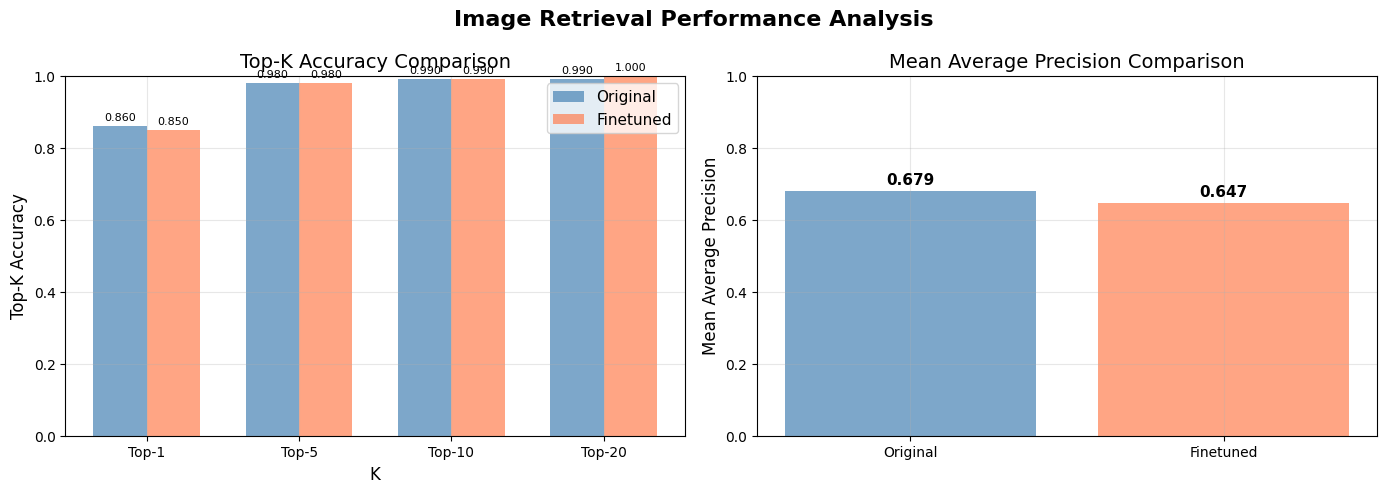

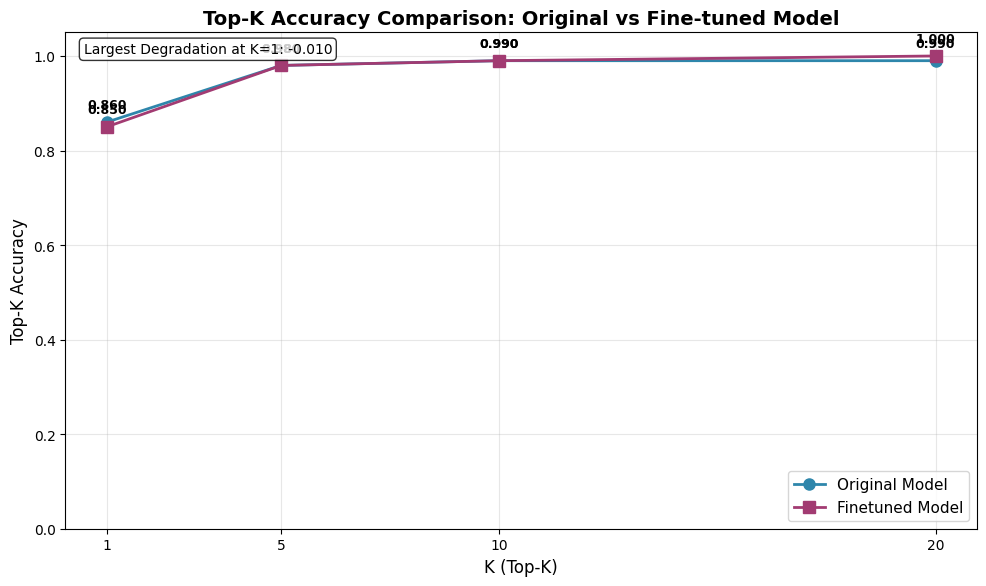

In [8]:
def plot_retrieval_performance():
    """Plot retrieval performance metrics with bar plots"""
    if not evaluation_results['results']:
        print("No results available for visualization")
        return
        
    results = evaluation_results['results']
    
    if len(results) == 1:
        # Single model visualization
        model_name = list(results.keys())[0]
        metrics = results[model_name]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Top-K accuracy plot
        k_vals = []
        acc_vals = []
        for metric, value in metrics.items():
            if 'Top-' in metric and 'Accuracy' in metric:
                k = int(metric.split('-')[1].split('_')[0])
                k_vals.append(k)
                acc_vals.append(value)
        
        bars1 = ax1.bar(range(len(k_vals)), acc_vals, color='steelblue', alpha=0.7)
        ax1.set_xlabel('K')
        ax1.set_ylabel('Top-K Accuracy')
        ax1.set_title(f'Top-K Accuracy - {model_name.title()}')
        ax1.set_xticks(range(len(k_vals)))
        ax1.set_xticklabels([f'Top-{k}' for k in k_vals])
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars1, acc_vals):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # mAP bar plot
        bars2 = ax2.bar([model_name.title()], [metrics['mAP']], color='steelblue', alpha=0.7)
        ax2.set_ylabel('Mean Average Precision')
        ax2.set_title('Mean Average Precision')
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value label
        ax2.text(bars2[0].get_x() + bars2[0].get_width()/2, bars2[0].get_height() + 0.01,
                f'{metrics["mAP"]:.3f}', ha='center', va='bottom', fontweight='bold')
        
    else:
        # Comparative visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Top-K accuracy comparison
        colors = ['steelblue', 'coral']
        for i, (model_name, metrics) in enumerate(results.items()):
            k_vals = []
            acc_vals = []
            for metric, value in metrics.items():
                if 'Top-' in metric and 'Accuracy' in metric:
                    k = int(metric.split('-')[1].split('_')[0])
                    k_vals.append(k)
                    acc_vals.append(value)
            
            x_positions = [x + i*0.35 for x in range(len(k_vals))]
            bars = ax1.bar(x_positions, acc_vals, width=0.35, 
                          color=colors[i], alpha=0.7, label=model_name.title())
            
            # Add value labels
            for bar, val in zip(bars, acc_vals):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax1.set_xlabel('K')
        ax1.set_ylabel('Top-K Accuracy')
        ax1.set_title('Top-K Accuracy Comparison')
        ax1.set_xticks([x + 0.175 for x in range(len(k_vals))])
        ax1.set_xticklabels([f'Top-{k}' for k in k_vals])
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, 1)
        
        # mAP comparison
        model_names = [name.title() for name in results.keys()]
        map_values = [metrics['mAP'] for metrics in results.values()]
        
        bars = ax2.bar(model_names, map_values, color=colors[:len(model_names)], alpha=0.7)
        ax2.set_ylabel('Mean Average Precision')
        ax2.set_title('Mean Average Precision Comparison')
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, value in zip(bars, map_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle('Image Retrieval Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'retrieval_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_k_comparison_curve():
    """Plot Top-K accuracy curves comparing original vs finetuned models"""
    if not evaluation_results['results']:
        print("No results available for K-comparison curve")
        return
        
    results = evaluation_results['results']
    
    if len(results) < 2:
        print("Need at least 2 models for comparison curve")
        return
    
    plt.figure(figsize=(10, 6))
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D']  # Professional color palette
    markers = ['o', 's', '^', 'D']
    
    for i, (model_name, metrics) in enumerate(results.items()):
        # Extract K values and corresponding accuracies
        k_vals = []
        acc_vals = []
        for metric, value in metrics.items():
            if 'Top-' in metric and 'Accuracy' in metric:
                k = int(metric.split('-')[1].split('_')[0])
                k_vals.append(k)
                acc_vals.append(value)
        
        # Sort by K values
        sorted_data = sorted(zip(k_vals, acc_vals))
        k_vals, acc_vals = zip(*sorted_data)
        
        # Plot curve for this model
        plt.plot(k_vals, acc_vals, 
                color=colors[i % len(colors)], 
                marker=markers[i % len(markers)], 
                linewidth=2, 
                markersize=8,
                label=f'{model_name.title()} Model')
        
        # Add value annotations
        for k, acc in zip(k_vals, acc_vals):
            plt.annotate(f'{acc:.3f}', 
                        (k, acc), 
                        textcoords="offset points", 
                        xytext=(0,10), 
                        ha='center',
                        fontsize=9,
                        fontweight='bold')
    
    plt.xlabel('K (Top-K)', fontsize=12)
    plt.ylabel('Top-K Accuracy', fontsize=12)
    plt.title('Top-K Accuracy Comparison: Original vs Fine-tuned Model', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)
    
    # Customize x-axis
    plt.xticks(k_vals)
    
    # Add improvement annotations if comparing original vs finetuned
    if 'original' in results and 'finetuned' in results:
        orig_metrics = results['original']
        ft_metrics = results['finetuned']
        
        # Find the biggest difference
        max_diff = 0
        max_diff_k = None
        for metric in orig_metrics.keys():
            if 'Top-' in metric and 'Accuracy' in metric:
                k = int(metric.split('-')[1].split('_')[0])
                diff = ft_metrics[metric] - orig_metrics[metric]
                if abs(diff) > abs(max_diff):
                    max_diff = diff
                    max_diff_k = k
        
        if max_diff_k is not None:
            improvement_text = "Improvement" if max_diff > 0 else "Degradation"
            plt.text(0.02, 0.98, f'Largest {improvement_text} at K={max_diff_k}: {max_diff:+.3f}', 
                    transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=10, 
                    verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'k_comparison_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate performance visualization
plot_retrieval_performance()

# Generate K-comparison curve
plot_k_comparison_curve()

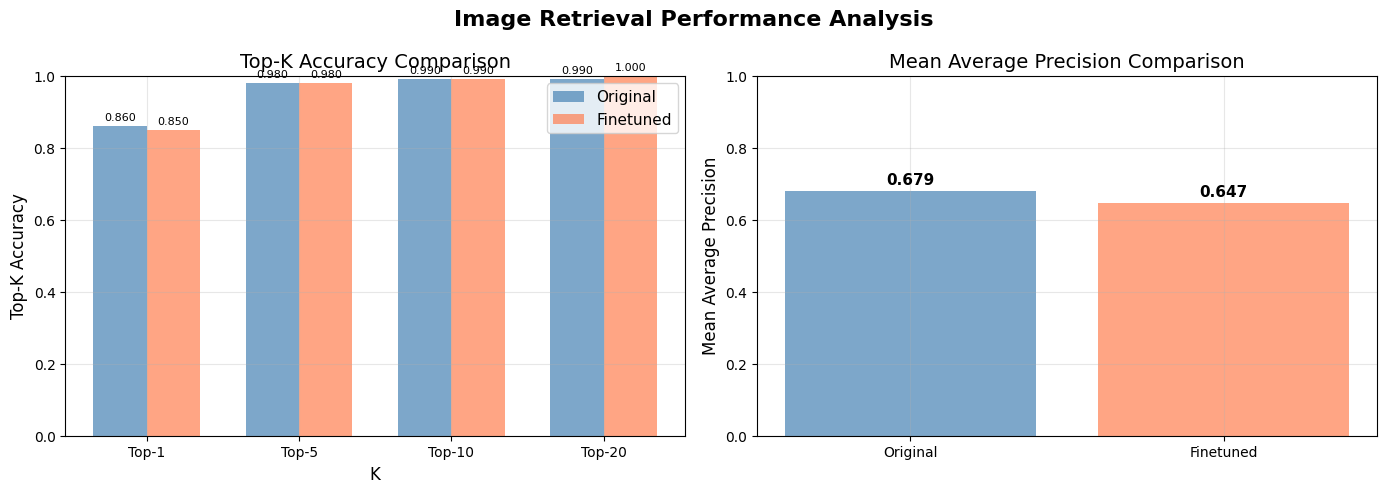

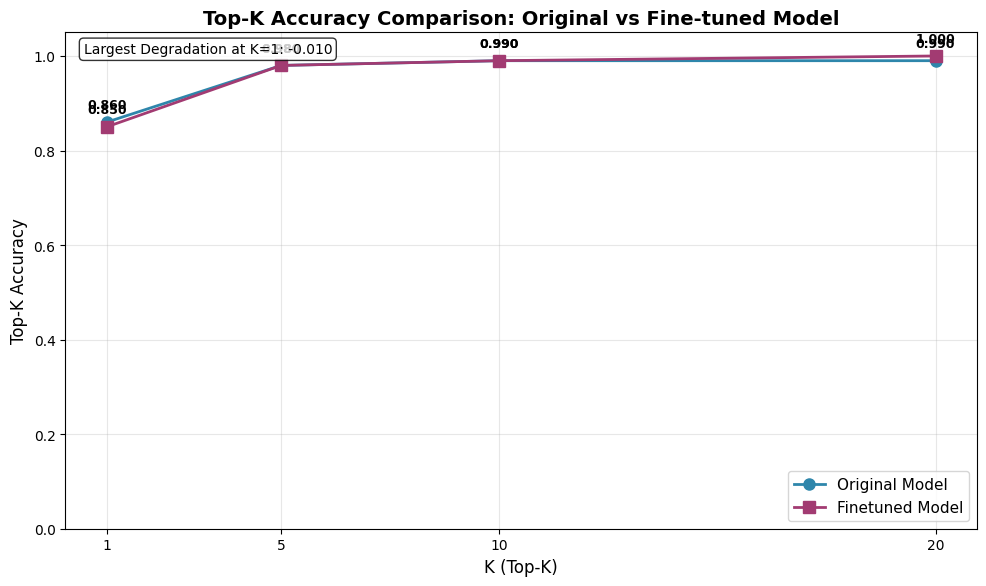

In [9]:
def plot_retrieval_performance():
    """Plot retrieval performance metrics with bar plots"""
    if not evaluation_results['results']:
        print("No results available for visualization")
        return
        
    results = evaluation_results['results']
    
    if len(results) == 1:
        # Single model visualization
        model_name = list(results.keys())[0]
        metrics = results[model_name]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Top-K accuracy plot
        k_vals = []
        acc_vals = []
        for metric, value in metrics.items():
            if 'Top-' in metric and 'Accuracy' in metric:
                k = int(metric.split('-')[1].split('_')[0])
                k_vals.append(k)
                acc_vals.append(value)
        
        bars1 = ax1.bar(range(len(k_vals)), acc_vals, color='steelblue', alpha=0.7)
        ax1.set_xlabel('K')
        ax1.set_ylabel('Top-K Accuracy')
        ax1.set_title(f'Top-K Accuracy - {model_name.title()}')
        ax1.set_xticks(range(len(k_vals)))
        ax1.set_xticklabels([f'Top-{k}' for k in k_vals])
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars1, acc_vals):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # mAP bar plot
        bars2 = ax2.bar([model_name.title()], [metrics['mAP']], color='steelblue', alpha=0.7)
        ax2.set_ylabel('Mean Average Precision')
        ax2.set_title('Mean Average Precision')
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value label
        ax2.text(bars2[0].get_x() + bars2[0].get_width()/2, bars2[0].get_height() + 0.01,
                f'{metrics["mAP"]:.3f}', ha='center', va='bottom', fontweight='bold')
        
    else:
        # Comparative visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Top-K accuracy comparison
        colors = ['steelblue', 'coral']
        for i, (model_name, metrics) in enumerate(results.items()):
            k_vals = []
            acc_vals = []
            for metric, value in metrics.items():
                if 'Top-' in metric and 'Accuracy' in metric:
                    k = int(metric.split('-')[1].split('_')[0])
                    k_vals.append(k)
                    acc_vals.append(value)
            
            x_positions = [x + i*0.35 for x in range(len(k_vals))]
            bars = ax1.bar(x_positions, acc_vals, width=0.35, 
                          color=colors[i], alpha=0.7, label=model_name.title())
            
            # Add value labels
            for bar, val in zip(bars, acc_vals):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{val:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax1.set_xlabel('K')
        ax1.set_ylabel('Top-K Accuracy')
        ax1.set_title('Top-K Accuracy Comparison')
        ax1.set_xticks([x + 0.175 for x in range(len(k_vals))])
        ax1.set_xticklabels([f'Top-{k}' for k in k_vals])
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, 1)
        
        # mAP comparison
        model_names = [name.title() for name in results.keys()]
        map_values = [metrics['mAP'] for metrics in results.values()]
        
        bars = ax2.bar(model_names, map_values, color=colors[:len(model_names)], alpha=0.7)
        ax2.set_ylabel('Mean Average Precision')
        ax2.set_title('Mean Average Precision Comparison')
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, value in zip(bars, map_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle('Image Retrieval Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'retrieval_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_k_comparison_curve():
    """Plot Top-K accuracy curves comparing original vs finetuned models"""
    if not evaluation_results['results']:
        print("No results available for K-comparison curve")
        return
        
    results = evaluation_results['results']
    
    if len(results) < 2:
        print("Need at least 2 models for comparison curve")
        return
    
    plt.figure(figsize=(10, 6))
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D']  # Professional color palette
    markers = ['o', 's', '^', 'D']
    
    for i, (model_name, metrics) in enumerate(results.items()):
        # Extract K values and corresponding accuracies
        k_vals = []
        acc_vals = []
        for metric, value in metrics.items():
            if 'Top-' in metric and 'Accuracy' in metric:
                k = int(metric.split('-')[1].split('_')[0])
                k_vals.append(k)
                acc_vals.append(value)
        
        # Sort by K values
        sorted_data = sorted(zip(k_vals, acc_vals))
        k_vals, acc_vals = zip(*sorted_data)
        
        # Plot curve for this model
        plt.plot(k_vals, acc_vals, 
                color=colors[i % len(colors)], 
                marker=markers[i % len(markers)], 
                linewidth=2, 
                markersize=8,
                label=f'{model_name.title()} Model')
        
        # Add value annotations
        for k, acc in zip(k_vals, acc_vals):
            plt.annotate(f'{acc:.3f}', 
                        (k, acc), 
                        textcoords="offset points", 
                        xytext=(0,10), 
                        ha='center',
                        fontsize=9,
                        fontweight='bold')
    
    plt.xlabel('K (Top-K)', fontsize=12)
    plt.ylabel('Top-K Accuracy', fontsize=12)
    plt.title('Top-K Accuracy Comparison: Original vs Fine-tuned Model', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.05)
    
    # Customize x-axis
    plt.xticks(k_vals)
    
    # Add improvement annotations if comparing original vs finetuned
    if 'original' in results and 'finetuned' in results:
        orig_metrics = results['original']
        ft_metrics = results['finetuned']
        
        # Find the biggest difference
        max_diff = 0
        max_diff_k = None
        for metric in orig_metrics.keys():
            if 'Top-' in metric and 'Accuracy' in metric:
                k = int(metric.split('-')[1].split('_')[0])
                diff = ft_metrics[metric] - orig_metrics[metric]
                if abs(diff) > abs(max_diff):
                    max_diff = diff
                    max_diff_k = k
        
        if max_diff_k is not None:
            improvement_text = "Improvement" if max_diff > 0 else "Degradation"
            plt.text(0.02, 0.98, f'Largest {improvement_text} at K={max_diff_k}: {max_diff:+.3f}', 
                    transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=10, 
                    verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'k_comparison_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate performance visualization
plot_retrieval_performance()

# Generate K-comparison curve
plot_k_comparison_curve()

In [10]:
class ResultsAnalyzer:
    """Comprehensive analysis and reporting of retrieval results"""
    
    def __init__(self, evaluation_results, config):
        self.results = evaluation_results['results']
        self.similarity_matrices = evaluation_results['similarity_matrices']
        self.top_k_indices = evaluation_results['top_k_indices']
        self.query_labels = evaluation_results['query_labels']
        self.gallery_labels = evaluation_results['gallery_labels']
        self.dataset_name = evaluation_results['dataset_name']
        self.label_names = evaluation_results['label_names']
        self.config = config
    
    def create_metrics_table(self):
        """Create detailed metrics comparison table with statistical analysis"""
        print("\n" + "=" * 60)
        print("DETAILED RETRIEVAL METRICS ANALYSIS")
        print("=" * 60)
        
        if not self.results:
            print("No results available for analysis")
            return pd.DataFrame()
        
        # Create comprehensive DataFrame
        metrics_data = []
        for model_name, metrics in self.results.items():
            row = {'Model': model_name.title()}
            row.update(metrics)
            metrics_data.append(row)
        
        df = pd.DataFrame(metrics_data)
        
        # Display results
        if len(df) == 1:
            print(f"Single Model Analysis: {df.iloc[0]['Model']}")
            print("-" * 40)
            for col in df.columns[1:]:
                print(f"  {col:>20}: {df.iloc[0][col]:>8.4f}")
        else:
            print("Multi-Model Comparison:")
            print("-" * 60)
            print(df.round(4).to_string(index=False))
            
            # Comparative analysis
            if len(df) == 2 and 'original' in self.results and 'finetuned' in self.results:
                print(f"\nImprovement Analysis (Fine-tuned vs Original):")
                print("-" * 50)
                orig_metrics = self.results['original']
                ft_metrics = self.results['finetuned']
                
                improvements = []
                for metric in orig_metrics.keys():
                    orig_val = orig_metrics[metric]
                    ft_val = ft_metrics[metric]
                    
                    if orig_val == 0:
                        if ft_val == 0:
                            improvement_str = "No change (both 0.0)"
                            improvement_val = 0.0
                        else:
                            improvement_str = f"+∞% (improved from 0.0 to {ft_val:.4f})"
                            improvement_val = float('inf')
                    else:
                        improvement_val = ((ft_val - orig_val) / orig_val) * 100
                        sign = '+' if improvement_val > 0 else ''
                        improvement_str = f"{sign}{improvement_val:.2f}%"
                    
                    improvements.append({
                        'Metric': metric,
                        'Original': f"{orig_val:.4f}",
                        'Fine-tuned': f"{ft_val:.4f}",
                        'Improvement': improvement_str
                    })
                    
                    print(f"  {metric:>20}: {improvement_str}")
        
        # Statistical summary
        self._print_statistical_summary()
        
        return df
    
    def _print_statistical_summary(self):
        """Print statistical summary of the evaluation"""
        print(f"\nEvaluation Statistics:")
        print("-" * 30)
        print(f"  Dataset: {self.dataset_name}")
        print(f"  Query samples: {len(self.query_labels)}")
        print(f"  Gallery samples: {len(self.gallery_labels)}")
        
        # Class distribution analysis
        query_classes = np.unique(self.query_labels)
        gallery_classes = np.unique(self.gallery_labels)
        common_classes = np.intersect1d(query_classes, gallery_classes)
        
        print(f"  Query classes: {len(query_classes)}")
        print(f"  Gallery classes: {len(gallery_classes)}")
        print(f"  Common classes: {len(common_classes)} ({len(common_classes)/len(query_classes)*100:.1f}% of query classes)")
        
        # Performance summary
        if self.results:
            all_metrics = list(self.results.values())[0].keys()
            
            print(f"\nPerformance Highlights:")
            for metric in all_metrics:
                values = [model_results[metric] for model_results in self.results.values()]
                best_idx = np.argmax(values)
                best_model = list(self.results.keys())[best_idx]
                best_value = values[best_idx]
                
                print(f"  Best {metric}: {best_model.title()} ({best_value:.4f})")

class ResultsSaver:
    """Handles saving and summarizing all retrieval analysis results"""
    
    def __init__(self, evaluation_results, config, output_dir):
        self.evaluation_results = evaluation_results
        self.config = config
        self.output_dir = output_dir
        self.results = evaluation_results['results']
        self.dataset_name = evaluation_results['dataset_name']
        
    def save_comprehensive_results(self, metrics_df=None):
        """Save all results with comprehensive metadata"""
        print("\n" + "=" * 50)
        print("SAVING COMPREHENSIVE RESULTS")
        print("=" * 50)
        
        # Save metrics to CSV if available
        if metrics_df is not None and not metrics_df.empty:
            csv_path = self.output_dir / 'retrieval_metrics.csv'
            metrics_df.to_csv(csv_path, index=False)
            print(f"  Metrics saved to: {csv_path}")
        else:
            print("  No metrics DataFrame to save")
        
        # Create comprehensive results JSON
        detailed_results = {
            'metadata': {
                'experiment_timestamp': pd.Timestamp.now().isoformat(),
                'dataset_type': self.config.DATASET_TYPE,
                'dataset_name': self.dataset_name,
                'similarity_metric': self.config.SIMILARITY_METRIC,
                'models_evaluated': list(self.results.keys()) if self.results else [],
                'k_values': self.config.K_VALUES,
            },
            'configuration': {
                'num_query_samples': self.config.NUM_QUERY_SAMPLES,
                'num_gallery_samples': self.config.NUM_GALLERY_SAMPLES,
                'batch_size': self.config.BATCH_SIZE,
                'random_seed': self.config.RANDOM_SEED,
                'feature_normalization': self.config.FEATURE_NORMALIZATION,
                'stratified_sampling': self.config.STRATIFIED_SAMPLING
            },
            'dataset_info': {
                'total_classes': len(np.unique(np.concatenate([
                    self.evaluation_results['query_labels'], 
                    self.evaluation_results['gallery_labels']
                ]))) if self.evaluation_results['query_labels'] is not None else 0,
                'query_classes': len(np.unique(self.evaluation_results['query_labels'])) if self.evaluation_results['query_labels'] is not None else 0,
                'gallery_classes': len(np.unique(self.evaluation_results['gallery_labels'])) if self.evaluation_results['gallery_labels'] is not None else 0,
                'query_samples': len(self.evaluation_results['query_labels']) if self.evaluation_results['query_labels'] is not None else 0,
                'gallery_samples': len(self.evaluation_results['gallery_labels']) if self.evaluation_results['gallery_labels'] is not None else 0
            },
            'results': self.results if self.results else {}
        }
        
        # Save detailed results as JSON
        json_path = self.output_dir / 'retrieval_analysis_complete.json'
        import json
        with open(json_path, 'w') as f:
            json.dump(detailed_results, f, indent=2)
        print(f"  Detailed results saved to: {json_path}")
        
        # List all generated files
        print(f"\nGenerated files in {self.output_dir}:")
        for file in sorted(self.output_dir.glob('*')):
            file_size = file.stat().st_size / 1024  # Size in KB
            print(f"  • {file.name:>30} ({file_size:>6.1f} KB)")
        
        return detailed_results
    
    def print_final_summary(self):
        """Print comprehensive final summary"""
        print("\n" + "=" * 70)
        print("IMAGE RETRIEVAL ANALYSIS - FINAL SUMMARY")
        print("=" * 70)
        
        # Dataset information
        print(f"Dataset Analysis:")
        print(f"  • Dataset: {self.dataset_name}")
        print(f"  • Type: {self.config.DATASET_TYPE}")
        print(f"  • Query samples: {len(self.evaluation_results['query_labels']) if self.evaluation_results['query_labels'] is not None else 0}")
        print(f"  • Gallery samples: {len(self.evaluation_results['gallery_labels']) if self.evaluation_results['gallery_labels'] is not None else 0}")
        
        # Model performance
        if self.results:
            print(f"\nModel Performance:")
            print(f"  • Models evaluated: {', '.join([name.title() for name in self.results.keys()])}")
            print(f"  • Similarity metric: {self.config.SIMILARITY_METRIC}")
            print(f"  • Evaluation metrics: Top-K Accuracy, Recall@K, mAP")
            
            # Best performing model summary
            if len(self.results) > 1:
                print(f"\nBest Performing Model by Metric:")
                all_metrics = list(self.results.values())[0].keys()
                for metric in all_metrics:
                    best_model = max(self.results.keys(), key=lambda x: self.results[x][metric])
                    best_score = self.results[best_model][metric]
                    print(f"  • {metric:>15}: {best_model.title():>12} ({best_score:>7.4f})")
            
            # Performance insights
            self._print_performance_insights()
        else:
            print(f"\nNo results generated - check model loading and feature extraction")
        
        print(f"\nResults Location: {self.output_dir}")
        print(f"Analysis completed successfully!")
    
    def _print_performance_insights(self):
        """Print insights about the performance results"""
        if not self.results:
            return
            
        print(f"\nPerformance Insights:")
        
        # Check if all metrics are zero
        all_metrics_zero = all(
            all(metric_value == 0.0 for metric_value in model_metrics.values())
            for model_metrics in self.results.values()
        )
        
        if all_metrics_zero:
            print(f"  All retrieval metrics are 0.0!")
            print(f"     Possible causes:")
            print(f"     - No matching classes between query and gallery sets")
            print(f"     - Feature extraction issues")
            print(f"     - Dataset sampling problems")
            
            # Provide diagnostic information
            if self.evaluation_results['query_labels'] is not None and self.evaluation_results['gallery_labels'] is not None:
                query_classes = set(self.evaluation_results['query_labels'])
                gallery_classes = set(self.evaluation_results['gallery_labels'])
                common_classes = query_classes & gallery_classes
                print(f"     - Query classes: {sorted(query_classes)}")
                print(f"     - Gallery classes: {sorted(gallery_classes)}")
                print(f"     - Common classes: {sorted(common_classes)} ({len(common_classes)} total)")
        else:
            # Successful analysis insights
            sample_metrics = list(self.results.values())[0]
            top1_scores = [model_metrics.get('Top-1_Accuracy', 0) for model_metrics in self.results.values()]
            avg_top1 = np.mean(top1_scores)
            
            if avg_top1 > 0.7:
                print(f"  Excellent retrieval performance! Average Top-1 Accuracy: {avg_top1:.3f}")
            elif avg_top1 > 0.4:
                print(f"  Good retrieval performance. Average Top-1 Accuracy: {avg_top1:.3f}")
            elif avg_top1 > 0.1:
                print(f"  Moderate retrieval performance. Average Top-1 Accuracy: {avg_top1:.3f}")
            else:
                print(f"  Low retrieval performance. Consider feature quality or dataset balance.")

# Initialize results analyzer
print("Initializing results analyzer...")
results_analyzer = ResultsAnalyzer(evaluation_results, RetrievalConfig)

# Create detailed metrics table
if evaluation_results['results']:
    metrics_df = results_analyzer.create_metrics_table()
else:
    print("No evaluation results available for analysis")
    metrics_df = pd.DataFrame()

print("\nMetrics analysis complete!")

Initializing results analyzer...

DETAILED RETRIEVAL METRICS ANALYSIS
Multi-Model Comparison:
------------------------------------------------------------
    Model  Top-1_Accuracy  Top-5_Accuracy  Top-10_Accuracy  Top-20_Accuracy    mAP
 Original            0.86            0.98             0.99             0.99 0.6793
Finetuned            0.85            0.98             0.99             1.00 0.6472

Improvement Analysis (Fine-tuned vs Original):
--------------------------------------------------
        Top-1_Accuracy: -1.16%
        Top-5_Accuracy: 0.00%
       Top-10_Accuracy: 0.00%
       Top-20_Accuracy: +1.01%
                   mAP: -4.72%

Evaluation Statistics:
------------------------------
  Dataset: jonathancui/oxford-pets
  Query samples: 100
  Gallery samples: 500
  Query classes: 35
  Gallery classes: 37
  Common classes: 35 (100.0% of query classes)

Performance Highlights:
  Best Top-1_Accuracy: Original (0.8600)
  Best Top-5_Accuracy: Original (0.9800)
  Best Top-10_

## Confusion Matrix Analysis

Too many classes (35) for confusion matrix display. Showing top 10 most frequent.
Too many classes (35) for confusion matrix display. Showing top 10 most frequent.


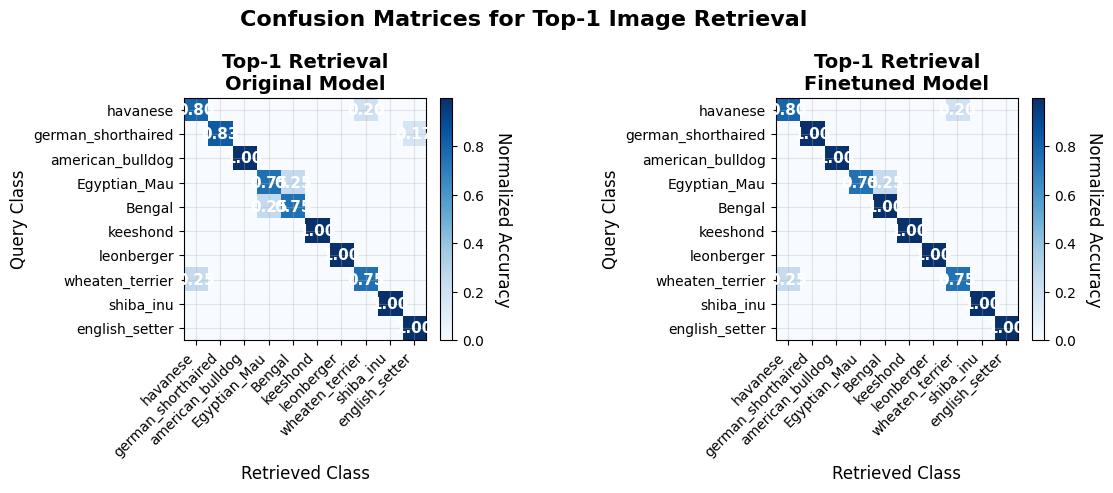

In [11]:
# Confusion matrix for retrieval performance
def plot_confusion_matrices():
    """Plot confusion matrices for Top-1 retrieval"""
    if not evaluation_results['results']:
        print("No results available for confusion matrix")
        return
        
    results = evaluation_results['results']
    top_k_indices_all = evaluation_results['top_k_indices'] 
    query_labels = evaluation_results['query_labels']
    gallery_labels = evaluation_results['gallery_labels']
    label_names = evaluation_results['label_names']
    
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, _) in enumerate(results.items()):
        ax = axes[i]
        
        # Get Top-1 predictions
        top1_indices = top_k_indices_all[model_name][:, 0]
        predicted_labels = gallery_labels[top1_indices]
        
        # Get unique classes that appear in both query and gallery
        unique_query_labels = np.unique(query_labels)
        unique_gallery_labels = np.unique(gallery_labels)
        common_labels = np.intersect1d(unique_query_labels, unique_gallery_labels)
        
        if len(common_labels) > 10:  # Limit to avoid overcrowded plot
            print(f"Too many classes ({len(common_labels)}) for confusion matrix display. Showing top 10 most frequent.")
            # Get most frequent classes
            label_counts = pd.Series(query_labels).value_counts()
            common_labels = label_counts.head(10).index.values
        
        # Filter data to common labels only
        mask = np.isin(query_labels, common_labels)
        filtered_query = query_labels[mask]
        filtered_pred = predicted_labels[mask]
        
        if len(filtered_query) > 0:
            cm = confusion_matrix(filtered_query, filtered_pred, labels=common_labels)
            
            # Normalize confusion matrix
            cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
            
            # Plot
            im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
            ax.set_title(f'Top-1 Retrieval\n{model_name.title()} Model', fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Normalized Accuracy', rotation=270, labelpad=20)
            
            # Set labels
            if RetrievalConfig.DATASET_TYPE == "huggingface":
                class_names = [label_names[label] for label in common_labels]
            else:
                class_names = [f'Class_{label}' for label in common_labels]
            
            ax.set_xticks(range(len(common_labels)))
            ax.set_yticks(range(len(common_labels)))
            ax.set_xticklabels(class_names, rotation=45, ha='right')
            ax.set_yticklabels(class_names)
            ax.set_xlabel('Retrieved Class')
            ax.set_ylabel('Query Class')
            
            # Add text annotations for values > 0.1
            for i_cm in range(len(common_labels)):
                for j_cm in range(len(common_labels)):
                    if cm_norm[i_cm, j_cm] > 0.1:
                        ax.text(j_cm, i_cm, f'{cm_norm[i_cm, j_cm]:.2f}',
                               ha="center", va="center", color="white", fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No common classes\nbetween query and gallery',
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(f'{model_name.title()} Model')
    
    plt.suptitle('Confusion Matrices for Top-1 Image Retrieval', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

if len(np.unique(evaluation_results['query_labels'])) > 1 and len(np.unique(evaluation_results['gallery_labels'])) > 1:
    plot_confusion_matrices()
else:
    print("Skipping confusion matrix - insufficient class diversity")

## Retrieval Examples Visualization

Generating retrieval examples...


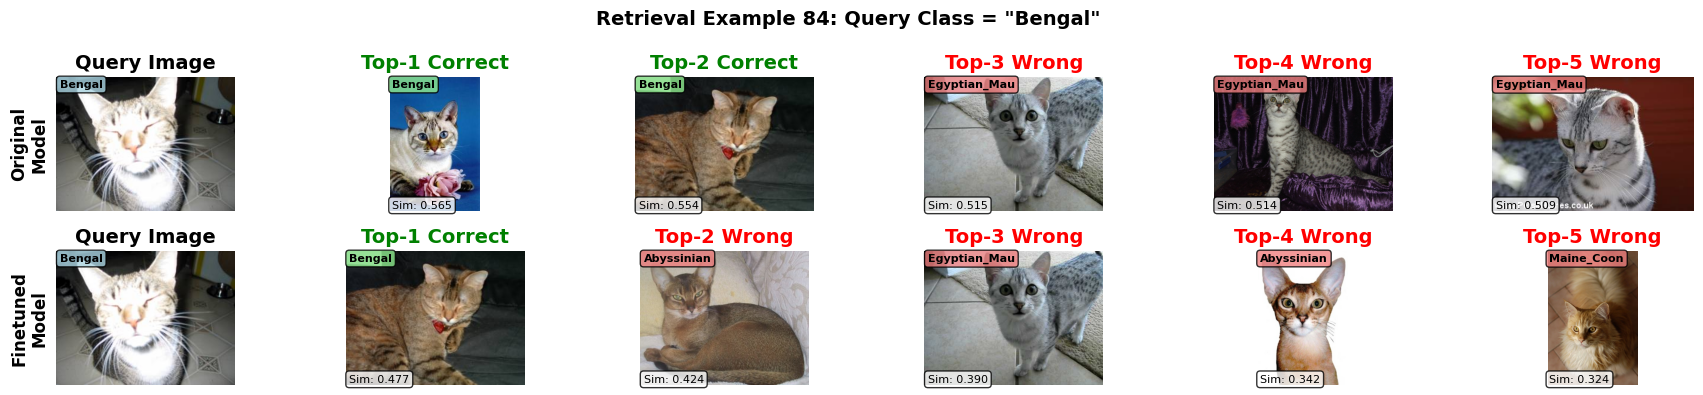

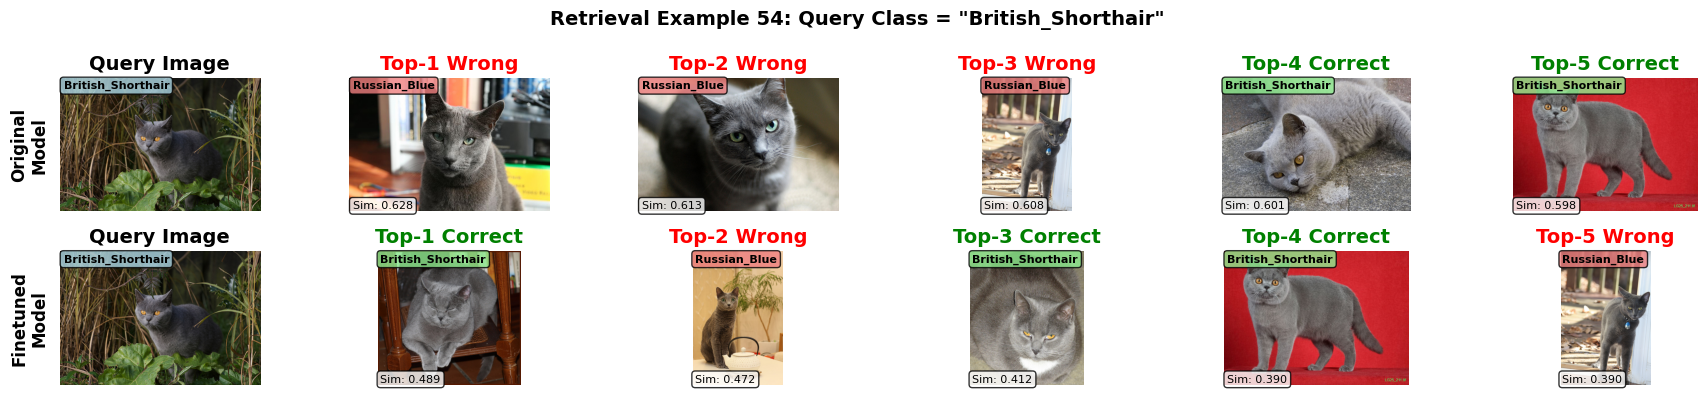

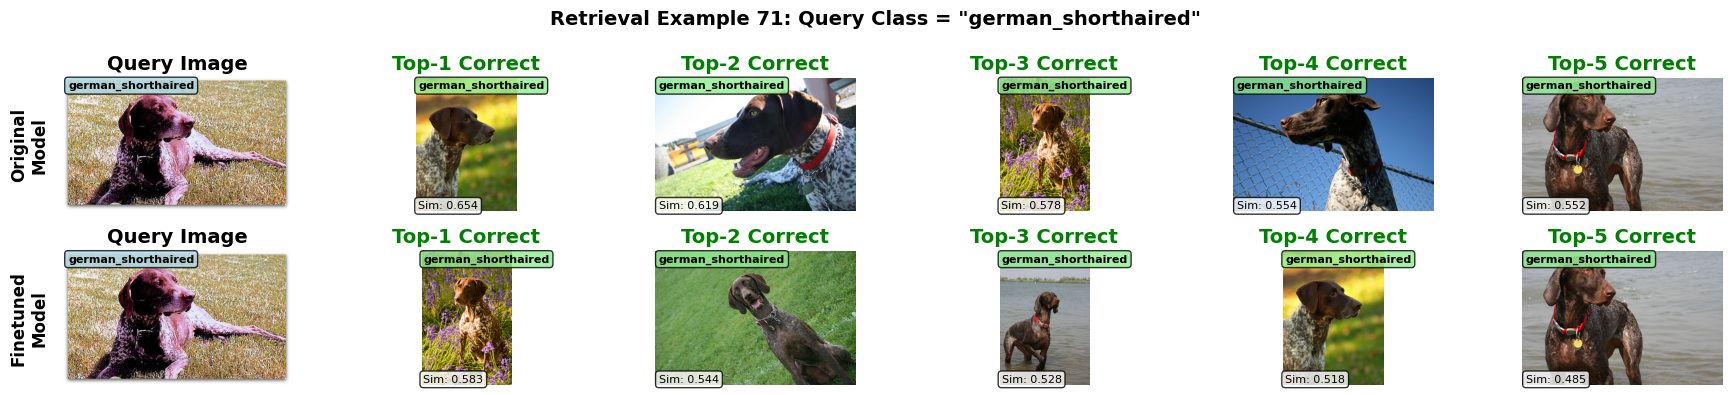

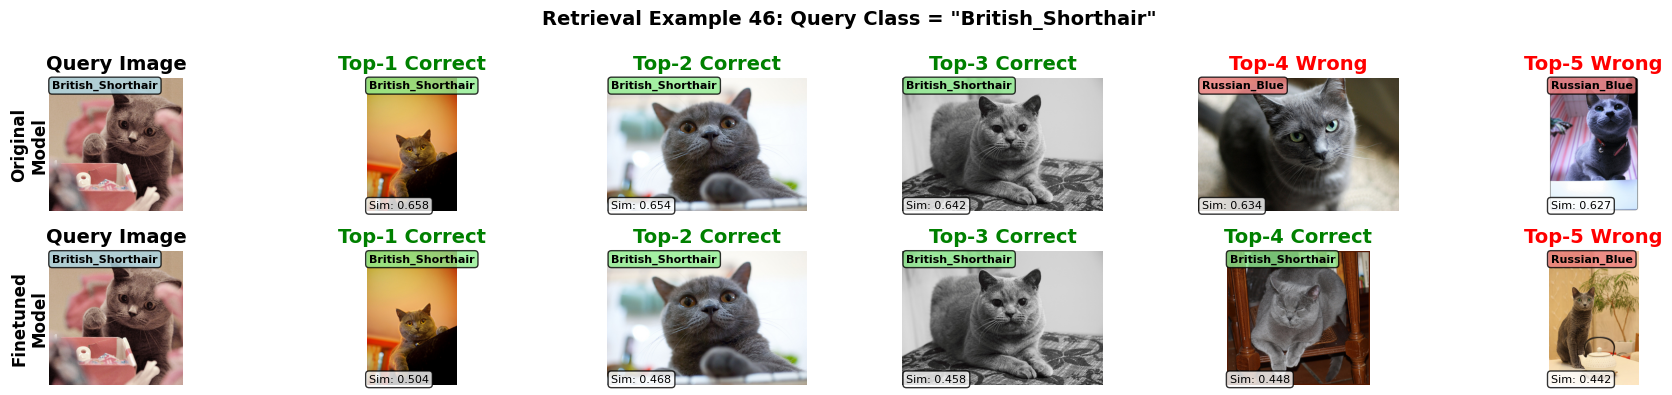

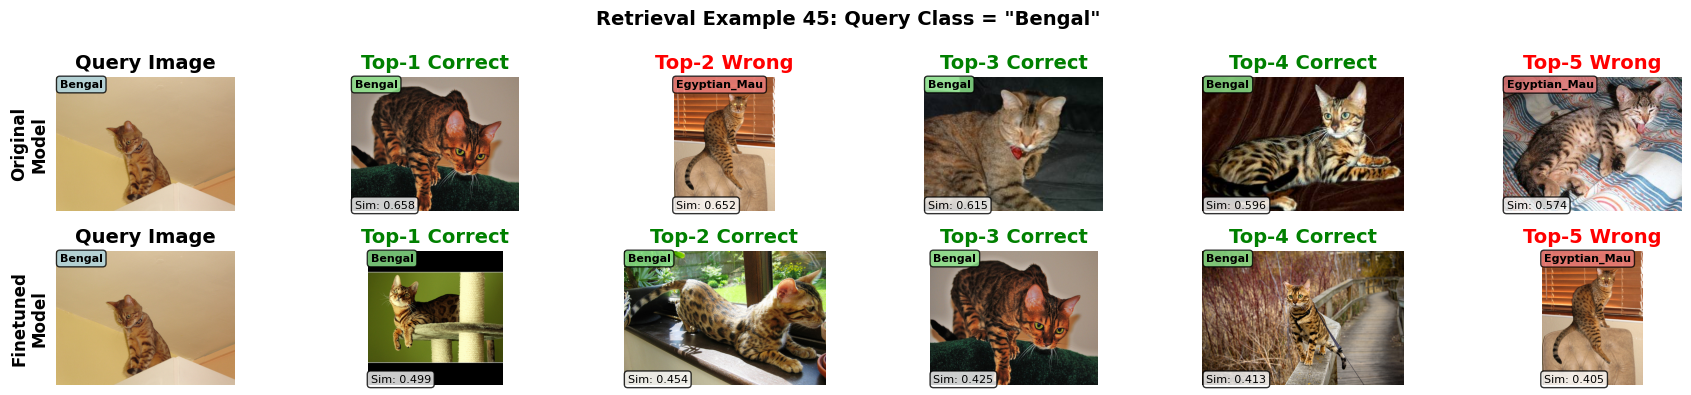

Retrieval examples generated


In [12]:
def get_image_from_dataset(dataset, index, dataset_type):
    """Get actual image from dataset"""
    try:
        if dataset_type == "huggingface":
            # For HuggingFace datasets - handle Subset wrapper
            if hasattr(dataset, 'dataset'):
                # This is a Subset, get the original dataset and map the index
                original_dataset = dataset.dataset
                if hasattr(dataset, 'indices'):
                    # Map subset index to original dataset index
                    original_index = dataset.indices[index]
                else:
                    original_index = index
                    
                # Get the image key from the original dataset
                if hasattr(original_dataset, 'image_key'):
                    image_key = original_dataset.image_key
                else:
                    image_key = 'image'  # default
                    
                # Access the original HuggingFace dataset
                if hasattr(original_dataset, 'dataset'):
                    hf_dataset = original_dataset.dataset
                    item = hf_dataset[original_index]
                    image = item[image_key]
                else:
                    item = original_dataset[original_index]
                    image = item[image_key]
            else:
                # Direct dataset access
                if hasattr(dataset, 'image_key'):
                    image_key = dataset.image_key
                else:
                    image_key = 'image'
                item = dataset.dataset[index] if hasattr(dataset, 'dataset') else dataset[index]
                image = item[image_key]
                
            if hasattr(image, 'convert'):
                return image.convert('RGB')
            return image
        else:
            # For custom datasets - handle Subset wrapper
            if hasattr(dataset, 'dataset'):
                # This is a Subset, get the original dataset and map the index
                original_dataset = dataset.dataset
                if hasattr(dataset, 'indices'):
                    original_index = dataset.indices[index]
                else:
                    original_index = index
                image_path = original_dataset.image_paths[original_index]
            else:
                # Direct dataset access
                image_path = dataset.image_paths[index]
            return Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image at index {index}: {e}")
        return None

def visualize_retrieval_examples():
    """Visualize retrieval examples with actual query and top-K result images"""
    if not evaluation_results['results']:
        print("No results available for visualization")
        return
        
    results = evaluation_results['results']
    top_k_indices_all = evaluation_results['top_k_indices'] 
    similarity_matrices = evaluation_results['similarity_matrices']
    query_labels = evaluation_results['query_labels']
    gallery_labels = evaluation_results['gallery_labels']
    label_names = evaluation_results['label_names']
    
    n_models = len(results)
    num_examples = min(RetrievalConfig.NUM_RETRIEVAL_EXAMPLES, len(query_labels))
    top_k_display = RetrievalConfig.TOP_K_DISPLAY
    
    # Get some example query indices
    example_indices = np.random.choice(len(query_labels), num_examples, replace=False)
    
    # Get dataset references
    query_dataset = query_dataloader.dataset
    gallery_dataset = gallery_dataloader.dataset
    
    for example_idx in example_indices:
        fig_height = 2 * n_models
        fig, axes = plt.subplots(n_models, top_k_display + 1, 
                                figsize=((top_k_display + 1) * 3, fig_height))
        
        if n_models == 1:
            axes = axes.reshape(1, -1)
        
        query_label = query_labels[example_idx]
        if RetrievalConfig.DATASET_TYPE == "huggingface":
            query_class_name = label_names[query_label]
        else:
            query_class_name = f'Class_{query_label}'
        
        # Load query image
        query_image = get_image_from_dataset(query_dataset, example_idx, RetrievalConfig.DATASET_TYPE)
        
        for model_idx, (model_name, _) in enumerate(results.items()):
            # Display query image
            if query_image is not None:
                axes[model_idx, 0].imshow(query_image)
            else:
                axes[model_idx, 0].text(0.5, 0.5, f'QUERY\n{query_class_name}', 
                                      transform=axes[model_idx, 0].transAxes, 
                                      ha='center', va='center', fontsize=10, fontweight='bold',
                                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            
            axes[model_idx, 0].set_title('Query Image', fontweight='bold')
            axes[model_idx, 0].axis('off')
            
            # Add query class name
            axes[model_idx, 0].text(0.02, 0.98, query_class_name, 
                                  transform=axes[model_idx, 0].transAxes,
                                  fontsize=8, fontweight='bold', 
                                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                                  verticalalignment='top')
            
            # Get top-K retrieved results
            if model_name in top_k_indices_all:
                top_k_idx = top_k_indices_all[model_name][example_idx, :top_k_display]
                
                for k_idx, retrieved_idx in enumerate(top_k_idx):
                    retrieved_label = gallery_labels[retrieved_idx]
                    
                    if RetrievalConfig.DATASET_TYPE == "huggingface":
                        retrieved_class_name = label_names[retrieved_label]
                    else:
                        retrieved_class_name = f'Class_{retrieved_label}'
                    
                    # Determine if retrieval is correct
                    is_correct = retrieved_label == query_label
                    color = 'lightgreen' if is_correct else 'lightcoral'
                    
                    # Load and display retrieved image
                    retrieved_image = get_image_from_dataset(gallery_dataset, retrieved_idx, RetrievalConfig.DATASET_TYPE)
                    
                    if retrieved_image is not None:
                        axes[model_idx, k_idx + 1].imshow(retrieved_image)
                    else:
                        axes[model_idx, k_idx + 1].text(0.5, 0.5, f'RANK {k_idx+1}\n{retrieved_class_name}', 
                                                      transform=axes[model_idx, k_idx + 1].transAxes,
                                                      ha='center', va='center', fontsize=9, fontweight='bold',
                                                      bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
                    
                    # Add class name overlay
                    axes[model_idx, k_idx + 1].text(0.02, 0.98, retrieved_class_name, 
                                                   transform=axes[model_idx, k_idx + 1].transAxes,
                                                   fontsize=8, fontweight='bold',
                                                   bbox=dict(boxstyle='round', facecolor=color, alpha=0.8),
                                                   verticalalignment='top')
                    
                    # Add similarity score
                    if model_name in similarity_matrices:
                        sim_score = similarity_matrices[model_name][example_idx, retrieved_idx]
                        axes[model_idx, k_idx + 1].text(0.02, 0.02, f'Sim: {sim_score:.3f}', 
                                                       transform=axes[model_idx, k_idx + 1].transAxes,
                                                       fontsize=8, 
                                                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                    # Set title with rank and correctness indicator
                    title = f'Top-{k_idx+1} {"Correct" if is_correct else "Wrong"}'
                    axes[model_idx, k_idx + 1].set_title(title, 
                                                         color='green' if is_correct else 'red',
                                                         fontweight='bold')
                    axes[model_idx, k_idx + 1].axis('off')
            
            # Add model name label
            axes[model_idx, 0].text(-0.15, 0.5, f'{model_name.title()}\nModel', 
                                  transform=axes[model_idx, 0].transAxes, 
                                  rotation=90, ha='center', va='center',
                                  fontsize=12, fontweight='bold')
        
        plt.suptitle(f'Retrieval Example {example_idx + 1}: Query Class = "{query_class_name}"', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f'retrieval_example_{example_idx + 1}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

print("Generating retrieval examples...")
visualize_retrieval_examples()
print("Retrieval examples generated")

## Results Summary

In [13]:
# Initialize results saver and save everything
print("Initializing results saver...")
results_saver = ResultsSaver(evaluation_results, RetrievalConfig, OUTPUT_DIR)

# Save all results
final_results = results_saver.save_comprehensive_results(
    metrics_df if 'metrics_df' in locals() else None
)

# Print final comprehensive summary
results_saver.print_final_summary()

print(f"\nImage retrieval analysis framework execution complete!")
print(f"Check the generated files for detailed results and visualizations.")

Initializing results saver...

SAVING COMPREHENSIVE RESULTS
  Metrics saved to: retrieval_results/retrieval_metrics.csv
  Detailed results saved to: retrieval_results/retrieval_analysis_complete.json

Generated files in retrieval_results:
  •         confusion_matrices.png ( 337.7 KB)
  •         k_comparison_curve.png ( 150.7 KB)
  • retrieval_analysis_complete.json (   1.0 KB)
  •       retrieval_example_45.png (4319.0 KB)
  •       retrieval_example_46.png (3264.7 KB)
  •       retrieval_example_54.png (4046.7 KB)
  •       retrieval_example_71.png (4730.4 KB)
  •       retrieval_example_84.png (3078.5 KB)
  •          retrieval_metrics.csv (   0.2 KB)
  •      retrieval_performance.png ( 176.9 KB)

IMAGE RETRIEVAL ANALYSIS - FINAL SUMMARY
Dataset Analysis:
  • Dataset: jonathancui/oxford-pets
  • Type: huggingface
  • Query samples: 100
  • Gallery samples: 500

Model Performance:
  • Models evaluated: Original, Finetuned
  • Similarity metric: cosine
  • Evaluation metrics: Top-K 